In [1]:
import sys
import os
from os import path
import time
from time import sleep

import tensorflow as tf
import numpy as np
# import cv2
# import matplotlib.pyplot as plt
import pylab as plt

from tqdm import tqdm, trange, tqdm_notebook, tnrange
import glob
import time
import pandas as pd
import h5py
import pickle as pkl
import subprocess as sp

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Config

In [2]:
slim_dir = "/mnt/workspace/models/research/slim/"
sys.path.insert(0, slim_dir)
from nets import vgg
image_size = vgg.vgg_16.default_image_size
# print(image_size)

from preprocessing import vgg_preprocessing

dataset_dir = "/mnt/workspace/datasets/UCF-101/"
label_dir = "/mnt/workspace/datasets/ucf101/ucf24/labels/"
batch_size = 16
checkpoints_dir = "/mnt/workspace/models/checkpoints/"

# means = [123.68, 116.779, 103.939]
means = [103.939, 116.779, 123.68]

## Define graph 

In [3]:
slim = tf.contrib.slim

with tf.Graph().as_default():
    input_batch = tf.placeholder(dtype=tf.uint8, shape=(batch_size,240,320,3))
    print(input_batch)
    
    
#     for j in range(batch_size):
#     normalized_images = vgg_preprocessing.preprocess_image(input_batch[0,...], image_size, image_size, is_training=False)
#     resized_images = tf.image.resize_images(tf.image.convert_image_dtype(input_batch, dtype=tf.float32),
#                                             [image_size,image_size]) # resize to default vgg size
#     print(resized_images)
#     normalized_images = tf.multiply(tf.subtract(resized_images, 0.5), 2.0) #normalise from {0,1} to {-1,1}


    resized_images = tf.image.resize_images(input_batch, [image_size,image_size])
    channels = tf.split(axis=3, num_or_size_splits=3, value=resized_images)
    for j in range(3):
        channels[j] -= means[j]
    normalized_images = tf.concat(axis=3, values=channels)
    
    with slim.arg_scope(vgg.vgg_arg_scope()):
        outputs, end_points = vgg.vgg_16(normalized_images,num_classes=1000, is_training=False)
        final_conv = end_points['vgg_16/conv5/conv5_3']
        fc7 = end_points['vgg_16/fc7']
        probablities = tf.nn.softmax(outputs)
        print(probablities)
        print(fc7)
    init_fn = slim.assign_from_checkpoint_fn(os.path.join(checkpoints_dir, 'vgg_16.ckpt'),slim.get_model_variables('vgg_16'))
    sess = tf.Session()
    init_fn(sess)

Tensor("Placeholder:0", shape=(16, 240, 320, 3), dtype=uint8)
Tensor("Softmax:0", shape=(16, 1000), dtype=float32)
Tensor("vgg_16/fc7/Relu:0", shape=(16, 1, 1, 4096), dtype=float32)
INFO:tensorflow:Restoring parameters from /mnt/workspace/models/checkpoints/vgg_16.ckpt


## Read data and extract features

In [4]:
labels = [x.replace(label_dir,"") for x in sorted(glob.glob(label_dir+"*"))]
print(labels)

['Basketball', 'BasketballDunk', 'Biking', 'CliffDiving', 'CricketBowling', 'Diving', 'Fencing', 'FloorGymnastics', 'GolfSwing', 'HorseRiding', 'IceDancing', 'LongJump', 'PoleVault', 'RopeClimbing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'Skijet', 'SoccerJuggling', 'Surfing', 'TennisSwing', 'TrampolineJumping', 'VolleyballSpiking', 'WalkingWithDog']


In [5]:
from IPython.display import clear_output
# with tqdm(total=len(labels)) as outer_pbar:
#     for category in labels:
#         all_videos = sorted(glob.glob(dataset_dir+category+"/*"))
#         with tqdm(total=len(all_videos)) as inner_pbar:
#             for video in all_videos:
#                 inner_pbar.set_description("Category Progress")
#                 inner_pbar.update(1)
#         clear_output()
#         outer_pbar.set_description("Total progress")
#         outer_pbar.update(1)
#     #     print(all_videos)

for i in tnrange(len(labels), desc='Total progress'):
    all_videos = sorted(glob.glob(dataset_dir+labels[i]+"/*"))
    for j in tnrange(len(all_videos), desc=labels[i], leave=False):
        video_path = all_videos[j]
        video_frames = read_video(video_path)
#         probablities_batch, features = sess.run([probablities, fc7], feed_dict={input_batch: video_frames})
        features = extract_features(video_frames)
#         sleep(0.1)

NameError: name 'read_video' is not defined

In [6]:
print(all_videos)

['/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g01_c01.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g01_c02.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g01_c03.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g01_c04.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g01_c05.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g01_c06.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g01_c07.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g02_c01.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g02_c02.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g02_c03.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g02_c04.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g02_c05.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g02_c06.avi', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g03_c01.avi', '/mnt

In [7]:
# def read_video(path):
command = [ 'ffmpeg',
#            '-i', '/mnt/workspace/datasets/UCF-101/BreastStroke/v_BreastStroke_g01_c01.avi',
#             '-i', '/mnt/workspace/datasets/UCF-101/BasketballDunk/v_BasketballDunk_g01_c01.avi',
           '-i', '/mnt/workspace/datasets/UCF-101/Basketball/v_Basketball_g01_c03.avi',
#            '-i', '/mnt/workspace/datasets/UCF-101/Billiards/v_Billiards_g01_c01.avi',
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-']
pipe = sp.Popen(command, stdout = sp.PIPE, bufsize=10**8)
video_frames = []
while True:
    # read 420*360*3 bytes (= 1 frame)
    raw_image = pipe.stdout.read(240*320*3)
#     print(type(raw_image))
    if len(raw_image) != 240*320*3:
        break;
    # transform the byte read into a numpy array
    image =  np.fromstring(raw_image, dtype='uint8')
    image = image.reshape((240,320,3))
#     image[:,:,0] = image[:,:,0] - 123.68
#     image[:,:,1] = image[:,:,1] - 116.78
#     image[:,:,2] = image[:,:,2] - 103.94
    video_frames.append(image)
    # throw away the data in the pipe's buffer.
    pipe.stdout.flush()
#     np.shape(image)
#     plt.imshow(image)
video_frames = np.asarray(video_frames, dtype=np.uint8)
# return video_frames

/mnt/workspace/miniconda3/envs/ebrnn/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


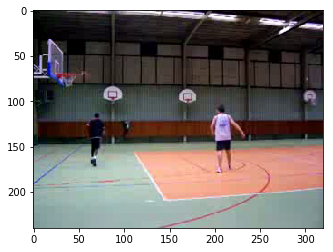

In [8]:
for img in video_frames[:1,:,:,:]:
    plt.figure()
    plt.imshow(img)

In [9]:
print(np.shape(video_frames))
print(np.shape(img))

(206, 240, 320, 3)
(240, 320, 3)


## Extract the features

In [10]:
for start, end in zip(range(0, video_frames.shape[0] + batch_size, batch_size),
                      range(batch_size, video_frames.shape[0] + batch_size, batch_size)):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-10-482477ea6337>, line 3)

In [11]:
from datasets import imagenet
names = imagenet.create_readable_names_for_imagenet_labels()
print(names)

{0: 'background', 1: 'tench, Tinca tinca', 2: 'goldfish, Carassius auratus', 3: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 4: 'tiger shark, Galeocerdo cuvieri', 5: 'hammerhead, hammerhead shark', 6: 'electric ray, crampfish, numbfish, torpedo', 7: 'stingray', 8: 'cock', 9: 'hen', 10: 'ostrich, Struthio camelus', 11: 'brambling, Fringilla montifringilla', 12: 'goldfinch, Carduelis carduelis', 13: 'house finch, linnet, Carpodacus mexicanus', 14: 'junco, snowbird', 15: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 16: 'robin, American robin, Turdus migratorius', 17: 'bulbul', 18: 'jay', 19: 'magpie', 20: 'chickadee', 21: 'water ouzel, dipper', 22: 'kite', 23: 'bald eagle, American eagle, Haliaeetus leucocephalus', 24: 'vulture', 25: 'great grey owl, great gray owl, Strix nebulosa', 26: 'European fire salamander, Salamandra salamandra', 27: 'common newt, Triturus vulgaris', 28: 'eft', 29: 'spotted salamander, Ambystoma maculatum'

In [ ]:
a = np.zeros((16, 720, 1280, 3), dtype=np.uint8)

In [ ]:
print(np.shape(a))
print(np.shape(video_frames))

In [12]:
video_frames = video_frames[:16,:,:,:]
probablities_batch, feats = sess.run([probablities, fc7], feed_dict={input_batch: video_frames})

In [13]:
print(np.shape(probablities_batch))

(16, 1000)


In [14]:
for i in range(batch_size):
    max_value = max(probablities_batch[i])
#     print(max_value)
    print(list(probablities_batch[i]).index(max_value))

890
890
890
890
890
890
890
890
890
890
890
890
890
890
890
890


In [ ]:
probabilities = probablities_batch[0, 0:]
sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]

In [ ]:
from datasets import imagenet
names = imagenet.create_readable_names_for_imagenet_labels()
for i in range(5):
    index = sorted_inds[i]
    # Shift the index of a class name by one. 
    print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index+1]))